In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.optimize import minimize
#import tensorflow_probability as tfp

In [175]:
def read_data(file):
    df = pd.read_excel(file, header=0)
    
    # Set plot style
    sns.set(style="whitegrid")

    # Create subplots
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

    # Plot each variable
    sns.lineplot(ax=axes[0], x=df.iloc[:, 0]/(24*60), y=df.iloc[:, 1])
    #axes[0].set_title('Temperature Over Time')

    sns.lineplot(ax=axes[1], x=df.iloc[:, 0]/(24*60), y=df.iloc[:, 2])
    #axes[1].set_title('pH Over Time')

    sns.lineplot(ax=axes[2], x=df.iloc[:, 0]/(24*60), y=df.iloc[:, 3])
    #axes[2].set_title('Dissolved Oxygen Over Time')

    # Improve layout
    plt.tight_layout()
    plt.show()
    
    obs_data = df.to_numpy()
    
    return obs_data

def oxygen_saturation(time, temp):
    A1=14.652
    A2=-0.41022
    A3=0.007991
    A4=-0.000077774
    C_sat=A1+A2*temp+A3*temp**2+A4*temp**3
    plot=1
    
    if plot == 1:
        plt.figure(figsize=(10, 8)) 
        plt.plot(time/(24*60), C_sat)
        plt.xlabel('Time [days]')
        plt.ylabel('Oxygen Saturation [mg/L]')
        plt.grid(True)
        plt.show()
    
    return C_sat

def atm_exchange(time, ox, Csat, k, h):
    atm=k/h*(Csat-ox)
    plot=1
    
    if plot == 1:
        plt.figure(figsize=(10, 8)) 
        plt.plot(time/(24*60), atm)
        plt.xlabel('Time [days]')
        plt.ylabel('Athm. Excahnge [mg/(L min)]')
        plt.grid(True)
        plt.show()
    
    return atm

def temp_limit(time, temp):
    
    phi_1=1.02
    gamma=1
    
    lim=phi_1**((temp-20)/gamma)
    plot=1
    
    if plot == 1:
        plt.figure(figsize=(10, 8)) 
        plt.plot(time/(24*60), lim)
        plt.xlabel('Time [days]')
        plt.ylabel('Temperature limitation [-]')
        plt.grid(True)
        plt.show()
    
    return lim

# 3. Interpolation helper for time-dependent coefficients
def interpolate_time_dependent(t_scalar, t_array, values):
    dt = t_array[1] - t_array[0]
    idx_float = (t_scalar - t_array[0]) / dt

    # Fix: convert everything to float32 for clipping
    idx0 = tf.clip_by_value(tf.floor(idx_float), 
                            tf.constant(0.0, dtype=tf.float32), 
                            tf.cast(tf.shape(t_array)[0] - 2, tf.float32))
    idx1 = idx0 + 1.0
    frac = idx_float - idx0

    # Indexing requires int32
    idx0 = tf.cast(idx0, tf.int32)
    idx1 = tf.cast(idx1, tf.int32)

    v0 = tf.gather(values, idx0)
    v1 = tf.gather(values, idx1)
    return (1 - frac) * v0 + frac * v1
   
    
# 4. ODE RHS with time-dependent known coefficients and trainable params
def ode_rhs(t_scalar, y, params):
    
    #state variables
    O=y[0]
    A=y[1]

    mu_max, SOD, Kl, FN, H, Iopt, eps0, lamb, R, c, Pm, Km, Rm, Cm, M, Z, time, temp_obs, Osat, FT1, I0 = params
    
    #interpolation for time_dpendent variables 
    #a_val = interpolate_time_dependent(t_scalar, t, a_t) #time dependent
    #b_val = interpolate_time_dependent(t_scalar, t, b_t) #time dependent
    
    #interpolation for time_dpendent variables
    FT1_t = interpolate_time_dependent(tf.constant(t_scalar, dtype=tf.float32), time, FT1) #time dependent
    I0_t = interpolate_time_dependent(tf.constant(t_scalar, dtype=tf.float32), time, I0)
    Cs_t = interpolate_time_dependent(tf.constant(t_scalar, dtype=tf.float32), time, Osat)
    
    #FL calculation--------------------------------
    numerator = tf.constant(2.718, dtype=tf.float32)
    eps = (eps0 + lamb*A)
    alpha = I0_t/Iopt*tf.exp(-eps*H) 
    denominator = eps * H
    exp1 = tf.exp(-alpha)
    exp2 = tf.exp(-I0_t / Iopt)
    FL = (numerator / denominator) * (exp1 - exp2)
   
    #Ip calculation--------------------------------
    Ip = I0_t*tf.exp(-eps*Z)

    mu=mu_max*FN*FL*FT1_t
    
    #Flux components-------------------------------
    Fatm=Kl/H*(Cs_t-O)
    Fprim=(mu-R)*A*c
    Fmac=(Pm*(Ip/(Ip+Km)*FT1_t-Rm))*Cm*M/H
    FSOD=SOD/(H*1000)
    
    #state variables-------------------------------
    dO=Fatm+Fprim+Fmac-FSOD
    dA=(mu-R)*A
    
    #dy1 = a_val * y[0] + theta1 * y[1]
    #dy2 = b_val * y[0] + theta2 * y[1]
    
    return tf.stack([dO, dA])

# 5. RK4 step implementation
def rk4_step(func, t_scalar, y, dt, params):
    k1 = func(t_scalar, y, params)
    k2 = func(t_scalar + dt/2, y + dt/2 * k1, params)
    k3 = func(t_scalar + dt/2, y + dt/2 * k2, params)
    k4 = func(t_scalar + dt, y + dt * k3, params)
    return y + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

# 6. RK4 integration over full time grid
def rk4_integrate(func, y0, t, params):
    ys = [y0]
    for i in range(len(t)-1):
        dt = t[i+1] - t[i]
        y_new = rk4_step(func, t[i], ys[-1], dt, params)
        ys.append(y_new)
    return tf.stack(ys)

def nse(y_obs, y_pred):
    y_obs_mean = tf.reduce_mean(y_obs, axis=0)
    numerator = tf.reduce_sum(tf.square(y_obs - y_pred), axis=0)
    denominator = tf.reduce_sum(tf.square(y_obs - y_obs_mean), axis=0)
    nse = 1.0 - numerator / (denominator + 1e-8)  # small epsilon to avoid divide-by-zero
    return nse


In [176]:
#Parameter section
#-----------------athmospheric exchange parameters
H = 1.1           #Depth of pond in [m]
Kl = 0.0006       #Exchange coefficient [m/min] (set for calibration)

#------------------sediment oxygen demand parameters
SOD= 4.68             #sediment oxygen demand [mg/(m^2 min)] (set for calibration)

#------------------Algae growth parameters
mu_max=0.008       #max growth rate [1/min] (set for calibration)
c=2                #Amount of oxygen production per g algal production [-]
Fn=1               #Nutrient limitation [-]
eps_0=0.5          #Background extinction [1/m]
lamb=1             #algal specific extinction [m2/g]
R=0.003            #Algal respiration rate [1/min] (set for calibration)
Iopt=400           #Optimal light availability [µE/m2s] (set for calibration)

#------------------Macrophytes parameter
Pm=0.000034        #Maximum oxygen production [1/min]
Km=250             #Light limitation macrophytes [µE/m2s]
Z=0.3              #Depth to plants [m]
M=8                #Average depth macrophytes [g/m2]
Cm=0.1             #Fraction covered
Rm=0.000032        #Macropphyte oxygen consumption [min^-1]


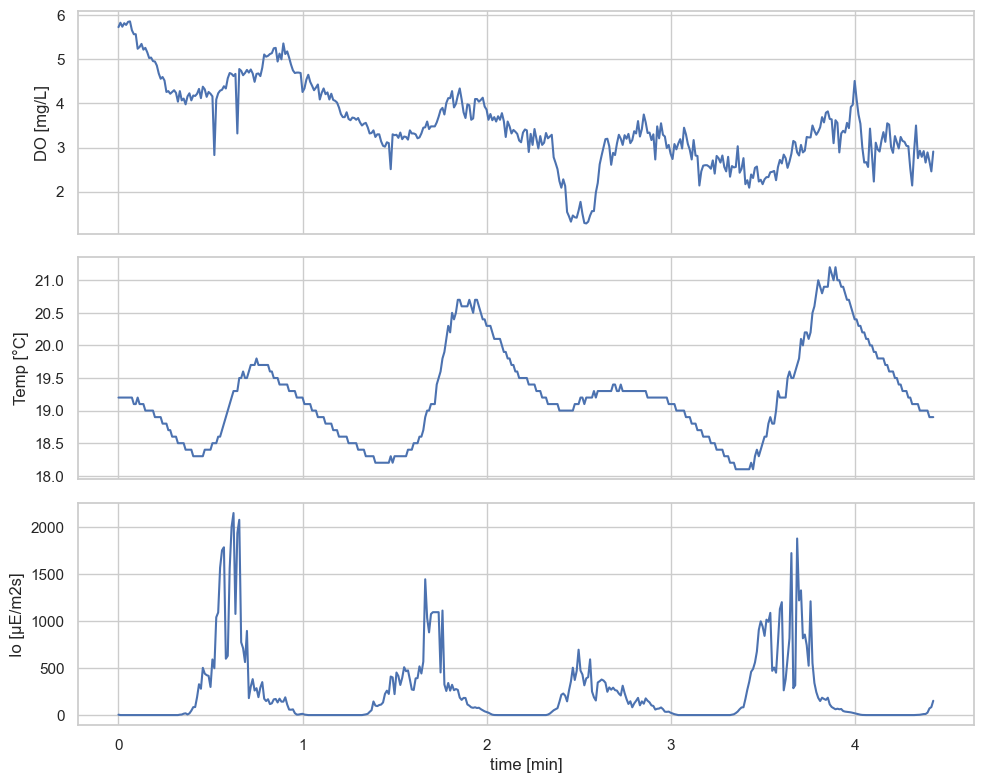

In [177]:
file = "Sensor-data pond 2022cor.xlsx"
obs_data=read_data(file)


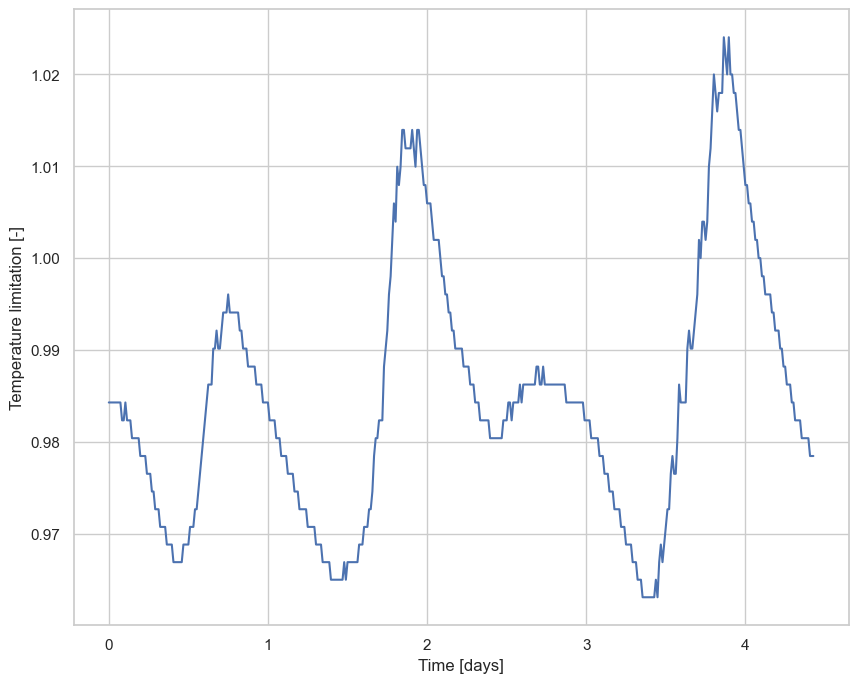

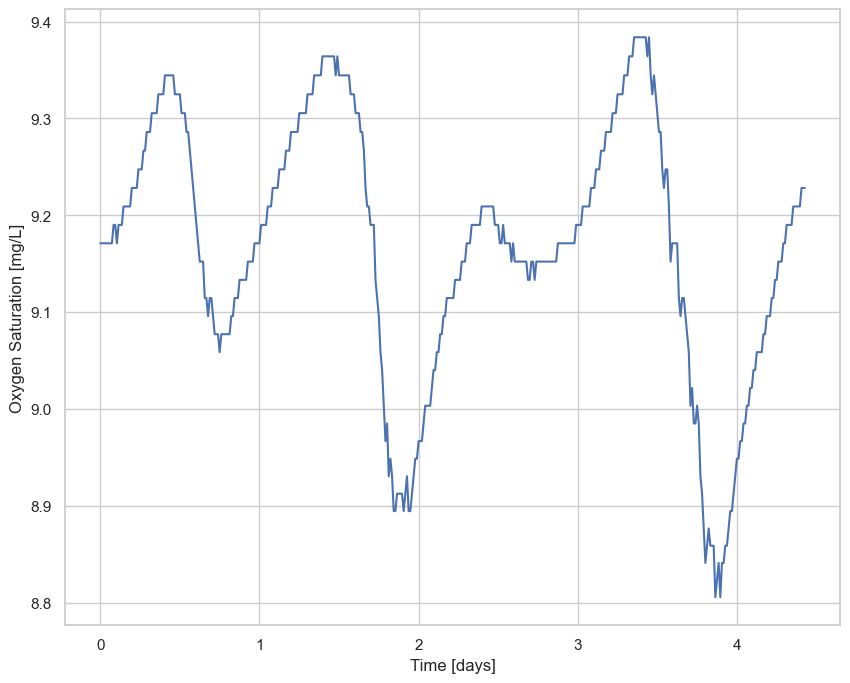

In [178]:
#------------------Initial conditions
O2_init=obs_data[0,1]   #initial conditions oxygen [mg/L]
A_init=0.6             #initial conditions algae [mg/L]



FT=temp_limit(obs_data[:,0], obs_data[:,2])
Csat=oxygen_saturation(obs_data[:,0], obs_data[:,2])
#F_atm=atm_exchange(obs_data[:,0], obs_data[:,1], Csat, Kl, H)


#Time dependent parameters
time=tf.convert_to_tensor(obs_data[:,0], dtype=tf.float32)
temp_obs=tf.convert_to_tensor(obs_data[:,2], dtype=tf.float32)
#FSOD=tf.convert_to_tensor(F_sod, dtype=tf.float32)
#Fatm=tf.convert_to_tensor(F_atm, dtype=tf.float32)
Osat=tf.convert_to_tensor(Csat, dtype=tf.float32)
FT1=tf.convert_to_tensor(FT, dtype=tf.float32)
I0=tf.convert_to_tensor(obs_data[:,3], dtype=tf.float32)


#Constant parameters
H=tf.constant(H, dtype=tf.float32)
FN=tf.constant(1, dtype=tf.float32)
Iopt=tf.constant(Iopt, dtype=tf.float32)
eps0=tf.constant(eps_0, dtype=tf.float32)
lamb=tf.constant(lamb, dtype=tf.float32)
#R=tf.constant(R, dtype=tf.float32)
c=tf.constant(c, dtype=tf.float32)
#Pm=tf.constant(Pm, dtype=tf.float32)
Km=tf.constant(Km, dtype=tf.float32)
#Rm=tf.constant(Rm, dtype=tf.float32)
Cm=tf.constant(Cm, dtype=tf.float32)
M=tf.constant(M, dtype=tf.float32)
Z=tf.constant(Z, dtype=tf.float32)
#mu_max = tf.constant(mu_max, dtype=tf.float32)
#SOD = tf.constant(SOD, dtype=tf.float32)
#Kl=tf.constant(Kl, dtype=tf.float32)
#Pm=tf.constant(Pm, dtype=tf.float32)

#Trainable parameters initialization
SOD = tf.Variable(SOD, dtype=tf.float32)
mu_max = tf.Variable(mu_max, dtype=tf.float32)
Kl=tf.Variable(Kl, dtype=tf.float32)
A_init=tf.Variable(A_init, dtype=tf.float32)
Pm=tf.Variable(Pm, dtype=tf.float32)
R=tf.Variable(R, dtype=tf.float32)
#Iopt=tf.Variable(Iopt, dtype=tf.float32)
#lamb=tf.Variable(lamb, dtype=tf.float32)

parameters =(mu_max, SOD, Kl, FN, H, Iopt, eps0, lamb, R, c, Pm, Km, Rm, Cm, M, Z, time, temp_obs, Osat, FT1, I0)

#print(FT.shape)

In [179]:
#initial conditions
O2_init=tf.constant(O2_init, dtype=tf.float32)
y0=[O2_init, A_init]
#y0 = tf.constant([O2_init, A_init], dtype=tf.float32)

#observtions
y_obs=tf.convert_to_tensor(obs_data[:,1], dtype=tf.float32)

# 9. Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1*10**(-5))

In [180]:
# 10. Training loop
best_loss = float('inf')
best_weights = None

#best_mu_max = tf.constant([], dtype=tf.float32)
#best_Kl = tf.constant([], dtype=tf.float32)
#best_A_init = tf.constant([], dtype=tf.float32)

for epoch in range(60):
    with tf.GradientTape() as tape:
        y_pred = rk4_integrate(ode_rhs, y0, time, parameters)
        #loss = tf.reduce_mean(tf.square(y_pred[:,0] - y_obs))
        loss = tf.reduce_sum(tf.square(y_pred[:,0] - y_obs))
        #loss = nse(y_obs,y_pred[:,0])
        
    #if epoch % 10 == 0:
    print(f"Epoch {epoch}: loss = {loss.numpy():.5f}, "
       f" mu_max = {mu_max.numpy()}, A_init = {A_init.numpy()}, R = {R.numpy()}, SOD = {SOD.numpy()}, Pm = {Pm.numpy()}, Kl = {Kl.numpy()} ")
    
    # Save best weights
    if loss < best_loss:
        best_loss = loss
        best_weights = [v.numpy() for v in [mu_max, A_init, R, SOD, Pm, Kl]]
    
    
    grads = tape.gradient(loss, [mu_max, A_init, R, SOD, Pm, Kl])
    optimizer.apply_gradients(zip(grads, [mu_max, A_init, R, SOD, Pm, Kl]))

    
    

# After training, restore best weights
for var, w in zip([mu_max, A_init, R, SOD, Pm, Kl], best_weights):
    var.assign(w)        

#y0=[O2_init, best_A_init]    
#parameters =(best_mu_max, SOD, best_Kl, FN, H, Iopt, eps0, lamb, R, c, Pm, Km, Rm, Cm, M, Z, time, temp_obs, Osat, FT1, I0)        
y_pred_best = rk4_integrate(ode_rhs, y0, time, parameters)        

final_loss = tf.reduce_sum(tf.square(y_pred_best[:, 0] - y_obs))
print(f"\nBest parameter set final loss: {final_loss.numpy():.6f}")


# Final estimated parameters
print(f"mu_max = {mu_max.numpy()}, A_init = {A_init.numpy()}, R = {R.numpy()}, SOD = {SOD.numpy()}, Pm = {Pm.numpy()}, Kl = {Kl.numpy()} ")
#print(f"True parameters:      theta1 = {true_theta1}, theta2 = {true_theta2}")

Epoch 0: loss = 521.24768,  mu_max = 0.00800000037997961, A_init = 0.6000000238418579, R = 0.003000000026077032, SOD = 4.679999828338623, Pm = 3.400000059627928e-05, Kl = 0.0006000000284984708 
Epoch 1: loss = 449.35406,  mu_max = 0.008009999990463257, A_init = 0.5999900102615356, R = 0.0029899999499320984, SOD = 4.679989814758301, Pm = 4.400000034365803e-05, Kl = 0.0006100000464357436 
Epoch 2: loss = 387.03159,  mu_max = 0.008019870147109032, A_init = 0.5999800562858582, R = 0.0029801081400364637, SOD = 4.6799798011779785, Pm = 5.3951600420987234e-05, Kl = 0.000619947153609246 
Epoch 3: loss = 333.84204,  mu_max = 0.008029461838304996, A_init = 0.5999701023101807, R = 0.002970440313220024, SOD = 4.679969787597656, Pm = 6.381703860824928e-05, Kl = 0.0006298013613559306 
Epoch 4: loss = 289.25092,  mu_max = 0.00803856085985899, A_init = 0.5999602675437927, R = 0.002961160149425268, SOD = 4.679960250854492, Pm = 7.355413981713355e-05, Kl = 0.0006395190139301121 
Epoch 5: loss = 252.6123

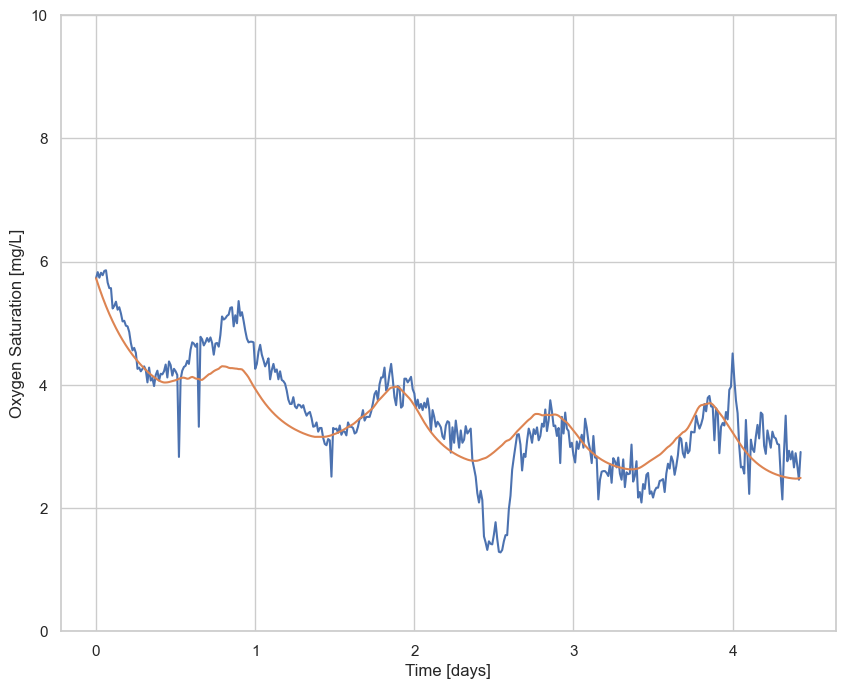

In [181]:
#test section
#a_val = interpolate_time_dependent(tf.constant(3500, dtype=tf.float32), time, temp_obs)
#print(a_val)


plt.figure(figsize=(10, 8)) 
plt.plot(obs_data[:,0]/(24*60), obs_data[:,1])
plt.plot(obs_data[:,0]/(24*60), y_pred_best[:, 0])

plt.xlabel('Time [days]')
plt.ylabel('Oxygen Saturation [mg/L]')
plt.ylim(0, 10)
plt.grid(True)
plt.show()

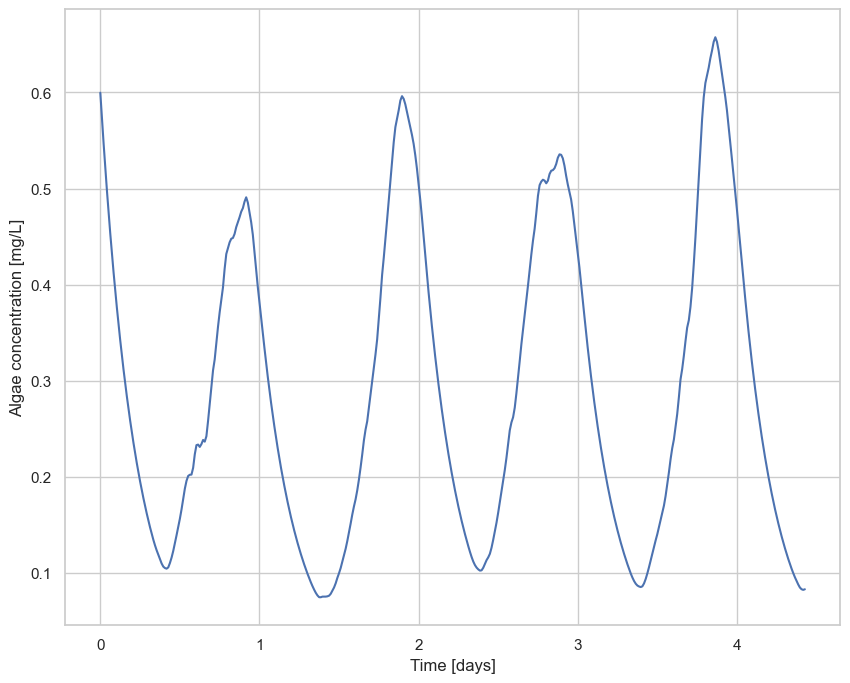

In [182]:
plt.figure(figsize=(10, 8)) 
#plt.plot(obs_data[:,0], obs_data[:,1])
plt.plot(obs_data[:,0]/(24*60), y_pred_best[:, 1])
plt.xlabel('Time [days]')
plt.ylabel('Algae concentration [mg/L]')
plt.grid(True)
plt.show()

In [213]:
alg=y_pred_best[:, 1].numpy()
O2=y_pred_best[:, 0].numpy()

F_SOD=(SOD/(H*1000)).numpy()
F_sod = np.full((len(obs_data[:,0]), 1), F_SOD)


F_aer=((Osat-O2)*Kl/H).numpy()

#FL calculation--------------------------------
numerator = tf.constant(2.718, dtype=tf.float32)
eps = (eps0 + lamb*y_pred_best[:, 1])
alpha = I0/Iopt*tf.exp(-eps*H) 
denominator = eps * H
exp1 = tf.exp(-alpha)
exp2 = tf.exp(-I0 / Iopt)
FL = (numerator / denominator) * (exp1 - exp2)

mu=mu_max*FN*FL*FT1
Ip = I0*tf.exp(-eps*Z)

Fprim=((mu-R)*y_pred_best[:, 1]*c).numpy()
Fmac=((Pm*(Ip/(Ip+Km)*FT1-Rm))*Cm*M/H).numpy()

Text(0, 0.5, 'Fmac [mg/(L min)]')

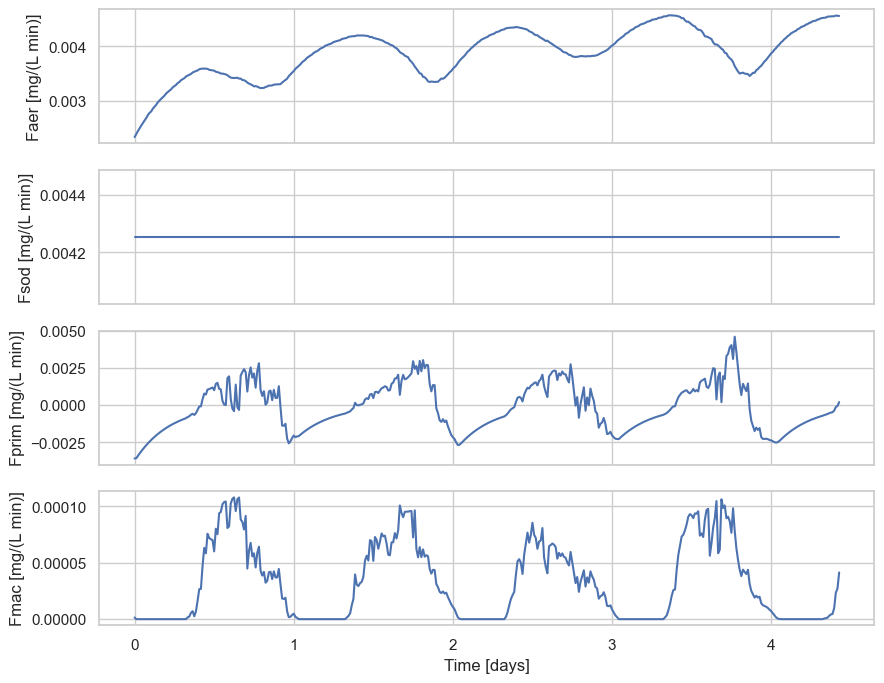

In [221]:
fig, axs = plt.subplots(4, 1, figsize=(10, 8))  # 1 row, 2 columns

axs[0].plot(obs_data[:,0]/(24*60), F_aer)
#axs[0].set_xlabel("Time [days]")
axs[0].set_ylabel("Faer [mg/(L min)]")
axs[0].set_xticklabels([])

axs[1].plot(obs_data[:,0]/(24*60), F_sod)
#axs[1].set_xlabel("Time [days]")
axs[1].set_ylabel("Fsod [mg/(L min)]")
axs[1].set_xticklabels([])

axs[2].plot(obs_data[:,0]/(24*60), Fprim)
#axs[2].set_xlabel("Time [days]")
axs[2].set_ylabel("Fprim [mg/(L min)]")
axs[2].set_xticklabels([])

axs[3].plot(obs_data[:,0]/(24*60), Fmac)
axs[3].set_xlabel("Time [days]")
axs[3].set_ylabel("Fmac [mg/(L min)]")

